## <h3 align="center"> __Johns Hopkins University__</h3>
## <h3 align="center">__Whiting School of Engineering__</h3>
## <h3 align="center">__Engineering for Professionals__</h3>
## <h3 align="center">__685.621 Algorithms for Data Science__</h3>
## <h3 align="center">__Programming Assignment 2__</h3>
## <h3 align="center">___________________________</h3>
## <h3 align="center">__Chris Mader__</h3>
## <h3 align="center">__cmader2@jh.edu__</h3>

In [1]:
# import libraries

import numpy as np
import pandas as pd
from itertools import combinations

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

import math
from scipy.stats.distributions import chi2

from cvxopt import matrix, solvers

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import dataset
X = pd.read_csv('mnist_60feat.csv', header=None)
y = pd.read_csv('train.csv').iloc[:X.shape[0], 0]

In [3]:
# EDA: summary statistics
X.describe()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,-182.986989,42.503455,224.223715,-333.170067,-193.186787,-330.419311,174.944430,57.943865,157.054438,111.098770,...,-52.916925,7.710837,14.368630,8.077462,28.112358,82.465349,-24.384102,13.302292,-27.412871,4.524001
std,413.563559,386.432887,317.113331,279.123247,257.135647,230.050151,208.799221,202.354707,194.174369,181.160926,...,132.061876,123.156730,119.972462,112.442752,108.125650,104.235439,100.214506,95.642214,90.864455,88.637630
min,-1444.368747,-1026.759861,-742.398170,-1349.588151,-1185.908526,-1433.552016,-582.787723,-669.897854,-553.603509,-638.902466,...,-586.148408,-496.950118,-404.457352,-394.490640,-390.253449,-307.456325,-407.076831,-445.229909,-426.112870,-346.523851
25%,-470.268196,-249.060251,19.600898,-506.152938,-369.831311,-463.754456,38.070853,-70.685554,36.237918,11.323718,...,-131.922300,-69.030244,-60.892948,-63.132199,-39.359200,14.957380,-86.052811,-45.702372,-84.354035,-51.412503
50%,-129.419579,-7.992520,178.362643,-319.484294,-175.948584,-307.251739,156.856495,51.584437,142.624012,100.535030,...,-41.784308,10.135182,4.764502,5.759329,28.691370,80.980827,-23.839394,14.472757,-24.286402,4.795670
75%,148.784674,241.714690,404.577297,-141.274486,-9.521441,-169.995454,310.273232,178.639955,271.828985,215.544738,...,28.998057,87.566313,86.253522,78.226054,93.700493,150.788006,39.116069,69.230176,31.119326,61.502019
max,908.959789,1486.132595,1533.966464,703.444179,647.768137,419.177410,1130.472246,996.545537,947.118754,921.893442,...,472.742831,447.888088,514.336821,488.351698,465.484156,442.925232,422.570655,474.801399,336.768066,315.682090


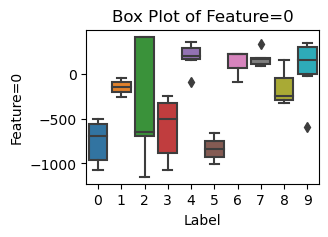

In [4]:
# EDA: box plot data visualisation

def generate_boxplot(df: pd.DataFrame, feature: int): 
    # df layout: rows=obs, cols=features, labels in last column
    df1 = df.iloc[:,[feature, -1]]
    plt.figure(figsize=(3,2))
    sns.boxplot(x='label', y=feature, data=df)
    plt.xlabel('Label')
    plt.ylabel('Feature=' + str(feature))
    plt.title('Box Plot of Feature=' + str(feature))
    plt.show()

feature = 0  # user input
generate_boxplot(pd.concat([X, y], axis=1).iloc[:50, :], feature)    

In [5]:
# convert to numpy arrays
X = X.to_numpy()
y = y.to_numpy()
assert X.shape ==  (5000, 60) and y.shape == (5000,)

In [6]:
# standardise data
# note: this is for feature selection only; to train ML models, use mean/stdev of X_train to compute z_scores of X_test

X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)
assert np.all(X_scaled.mean(axis=0).round(4) == 0)
assert np.all(X_scaled.std(axis=0).round(4) == 1)

# X_scaled = (X.max(axis=0) - X) / (X.max(axis=0) - X.min(axis=0))
# assert np.all(X_scaled.min(axis=0).round(4) == 0)
# assert np.all(X_scaled.max(axis=0).round(4) == 1)

# Question 1 - Feature Ranking

## 1.1. Feature Ranking with FDR

#### Approach

* For each class (digit from 0-9), separate the data into the selected 'one-hot' class and all other classes (one-vs-all), then loop over each feature.
* For each feature, compute the FDR value between the selected class and all other classes, then select the feature with the highest FDR value using argmax, before storing the best_feature in a dictionary.
* Return a dictionary containing best_feature per class, i.e. the feature that best separates the selected class from the rest.
* Added decision-tree based feature ranking for comparison, which is covered in more details in 1.2.


In [7]:
class FeatureRanking:
    
    """
    Description: contains feature ranking functions fdr_best_features and tree_best_features.
    """
    
    def __init__(self):
        pass    
    
    def convert_to_one_hot(self, y, label):
        y_one_hot = y.copy()
        y_one_hot[y==label] = 1
        y_one_hot[y!=label] = 0
        return y_one_hot
    
    def fdr_best_features(self, X: pd.DataFrame or np.array, y: pd.Series or np.array) -> dict:
        """
        Description: ranks features based on Fisher's iscriminant ratio (FDR), using a one-vs-all approach
        Input: X (=data), y (=labels), numpy arrays or df.
        Output: a dictionary of features (keys) and their fdr values (values)
        """
    
        X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        y = y.to_numpy() if isinstance(y, pd.Series) else y
    
        # FDR calculation:
        def get_fdr(arr1: np.array, arr2: np.array) -> float:
            mu1, mu2 = np.mean(arr1), np.mean(arr2)
            std1, std2 = np.std(arr1), np.std(arr2)
            fdr = (mu1 - mu2)**2 / (std1**2 + std2**2)
            return fdr        

        # create array of unique features
        labels = np.unique(y)  
        
        # initialise a dict to store labels (=keys), list of best features, in descending order (=values)
        best_features = {}
        
        # for each class (label), calculate the fdr between the selected class and all other classes
        for label in labels:
            label_fdrs = []
            for feature in range(X.shape[1]):
                arr1 = X[y==label][:, feature]
                arr2 = X[y!=label][:, feature]
                fdr = get_fdr(arr1, arr2)
                label_fdrs.append(fdr)
            best_features[label] = pd.Series(label_fdrs).sort_values(ascending=False).index.to_list()
        
        return best_features
    
    def tree_best_features(self, X: pd.DataFrame or np.array, y: pd.Series or np.array,
                           max_depth=10, random_state=1) -> dict:
        """
        Description: ranks features based on sklearn's DecisionTree classifier, using a one-vs-all approach
        Input: X (=data), y (=labels), numpy arrays or df.
        Output: a dictionary of features (keys) and their fdr values (values)
        """
        
        X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        y = y.to_numpy() if isinstance(y, pd.Series) else y
        
        # create array of unique features
        labels = np.unique(y)  
        
        # initialise a dict to store labels (=keys), list of best features, in descending order (=values)
        best_features = {}
        
        # 
        for label in labels:
            y_one_hot = self.convert_to_one_hot(y, label)
            model = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)
            model.fit(X, y_one_hot)    
            best_features[label] = pd.Series(model.feature_importances_).sort_values(ascending=False).index.to_list()
        
        return best_features


In [8]:
# FDR-based feature ranking: summary with top feature per class, and full list of features ranked in descending order

fdr_best_features = FeatureRanking().fdr_best_features(X_scaled, y)

fdr_best_features_summary = [(label, best_features[0]) for label, best_features in fdr_best_features.items()]
print(f'FDR - best features summary:\n(label, best_feature) = {fdr_best_features_summary}\n')

for label, best_features in fdr_best_features.items():
    print(f'\nlabel={label}, best_features (in descending order) = {best_features}')

FDR - best features summary:
(label, best_feature) = [(0, 20), (1, 20), (2, 1), (3, 42), (4, 0), (5, 49), (6, 1), (7, 43), (8, 8), (9, 0)]


label=0, best_features (in descending order) = [20, 40, 2, 44, 21, 0, 46, 6, 22, 41, 42, 26, 5, 23, 39, 49, 19, 29, 27, 33, 52, 47, 3, 58, 12, 8, 18, 13, 28, 9, 36, 30, 35, 31, 57, 50, 17, 54, 1, 32, 11, 4, 16, 15, 14, 51, 48, 34, 24, 10, 37, 55, 53, 56, 59, 38, 43, 7, 45, 25]

label=1, best_features (in descending order) = [20, 21, 5, 3, 30, 52, 28, 46, 23, 42, 4, 40, 31, 51, 19, 50, 17, 32, 41, 6, 2, 11, 59, 9, 39, 55, 57, 12, 38, 56, 29, 24, 10, 8, 26, 43, 37, 35, 0, 22, 36, 49, 45, 13, 58, 53, 44, 54, 34, 15, 48, 18, 33, 16, 14, 25, 47, 1, 27, 7]

label=2, best_features (in descending order) = [1, 51, 40, 4, 34, 47, 3, 46, 42, 45, 6, 48, 25, 9, 23, 11, 28, 8, 19, 21, 12, 29, 16, 35, 24, 39, 27, 0, 10, 57, 5, 7, 37, 38, 52, 59, 13, 55, 33, 15, 31, 58, 54, 22, 43, 53, 2, 17, 56, 26, 30, 50, 49, 18, 36, 44, 20, 32, 14, 41]

label=3, best_features

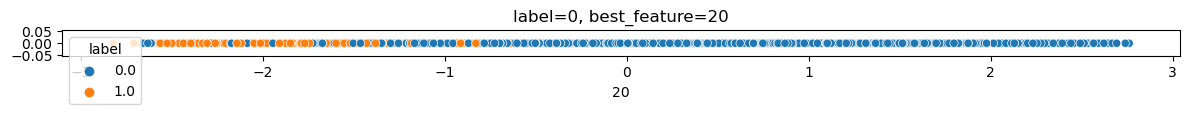

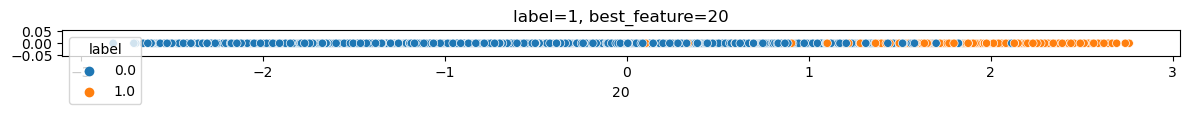

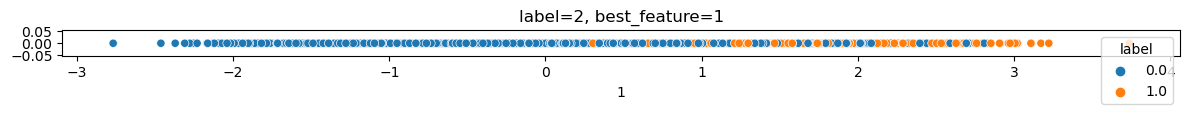

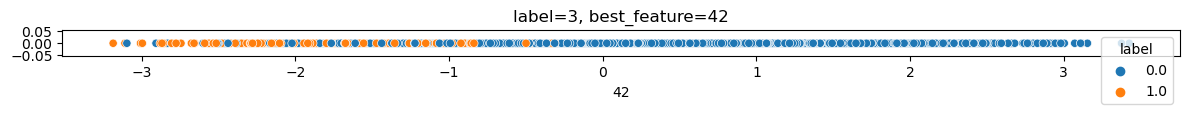

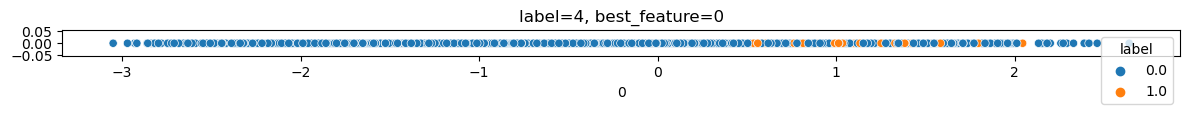

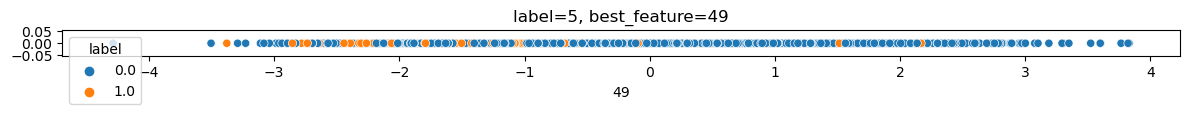

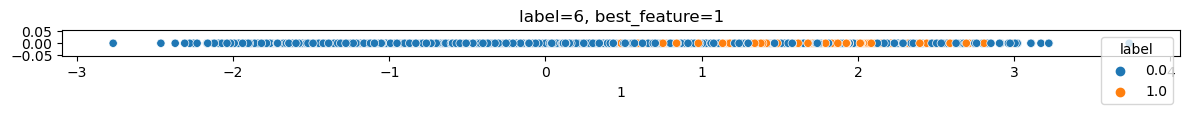

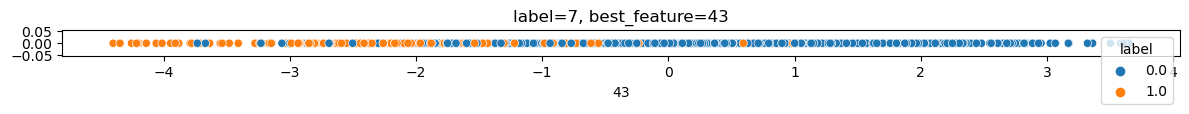

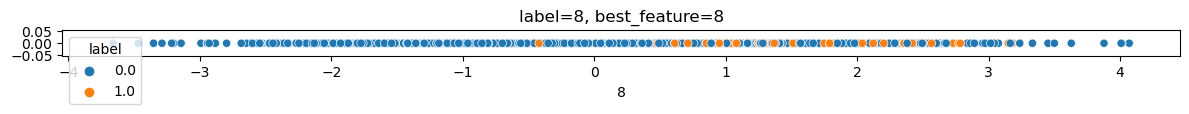

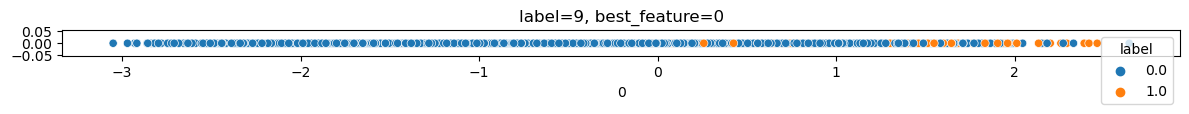

In [9]:
# FDR-based feature ranking: plot of best_feature vs rest

for label, best_features in fdr_best_features.items():
    y_one_hot = FeatureRanking().convert_to_one_hot(y, label)
    df_temp = pd.DataFrame(data=np.vstack(
        (X_scaled[:, best_features[0]], y_one_hot)).T, columns=[best_features[0], 'label'])
    plt.figure(2, figsize=(12, 1.2))
    sns.scatterplot(data=df_temp, x=df_temp.columns[0], y=[0]*len(df_temp), hue='label', palette='tab10')
    plt.title('label=' + str(label) + ', best_feature=' + str(best_features[0]))
    plt.tight_layout()
    plt.show()

In [10]:
# Decision tree-based feature ranking: summary with top feature per class, and full list of features ranked in descending order

tree_best_features = FeatureRanking().tree_best_features(X_scaled, y)

tree_best_features_summary = [(label, best_features[0]) for label, best_features in tree_best_features.items()]
print(f'Tree - best features summary:\n(label, best_feature) = {tree_best_features_summary}\n')

for label, best_features in tree_best_features.items():
    print(f'\nlabel={label}, best_features (in descending order) = {best_features}') 

Tree - best features summary:
(label, best_feature) = [(0, 20), (1, 20), (2, 1), (3, 42), (4, 0), (5, 8), (6, 1), (7, 2), (8, 40), (9, 2)]


label=0, best_features (in descending order) = [20, 0, 40, 2, 41, 44, 43, 42, 22, 1, 6, 58, 49, 30, 25, 46, 51, 21, 23, 11, 57, 47, 38, 4, 26, 8, 3, 59, 34, 52, 56, 32, 9, 50, 53, 54, 48, 55, 45, 5, 7, 14, 10, 39, 16, 17, 18, 19, 13, 12, 24, 27, 28, 29, 31, 33, 35, 36, 15, 37]

label=1, best_features (in descending order) = [20, 1, 3, 0, 8, 27, 21, 43, 45, 57, 50, 23, 31, 32, 55, 40, 36, 48, 46, 14, 24, 12, 13, 33, 54, 16, 47, 29, 35, 26, 28, 37, 51, 49, 58, 52, 53, 56, 44, 41, 42, 30, 39, 38, 2, 4, 5, 6, 7, 9, 10, 11, 15, 17, 18, 19, 22, 25, 34, 59]

label=2, best_features (in descending order) = [1, 40, 42, 4, 51, 6, 9, 0, 22, 3, 20, 8, 44, 7, 53, 10, 11, 19, 17, 12, 33, 34, 2, 25, 47, 37, 31, 49, 30, 29, 43, 57, 45, 26, 58, 21, 15, 13, 24, 46, 27, 28, 50, 52, 14, 54, 55, 56, 5, 16, 48, 18, 41, 39, 38, 23, 36, 35, 32, 59]

label=3, best_features

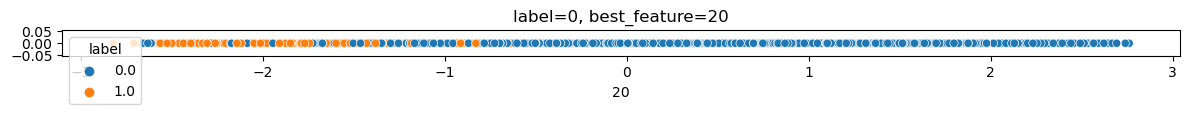

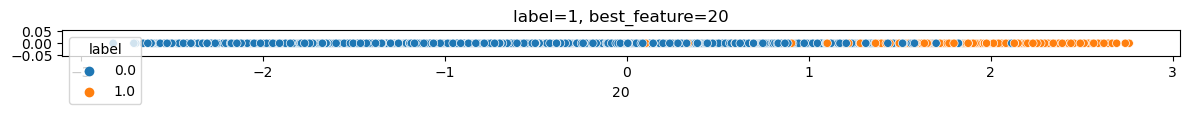

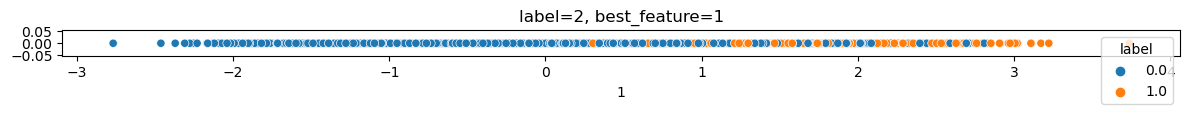

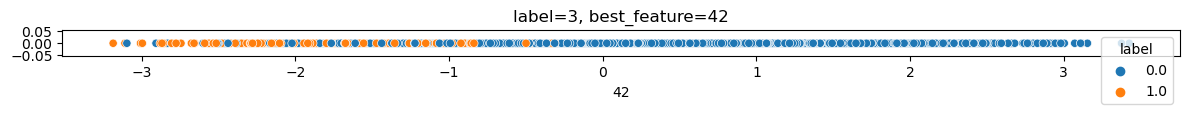

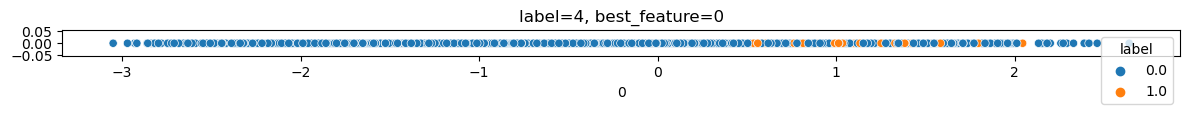

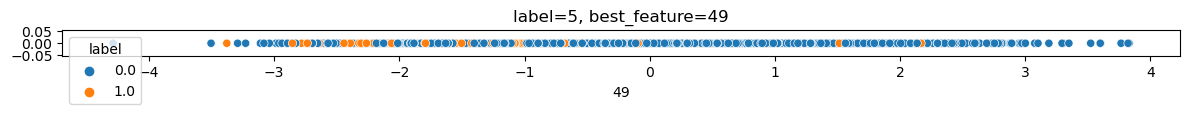

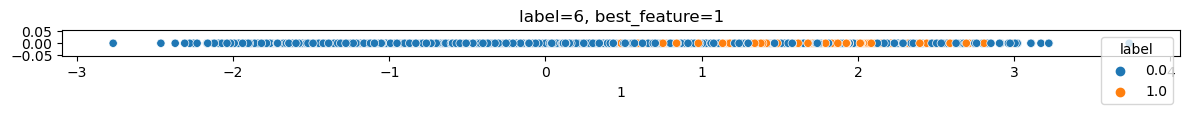

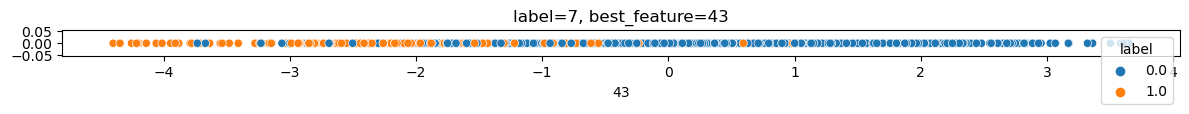

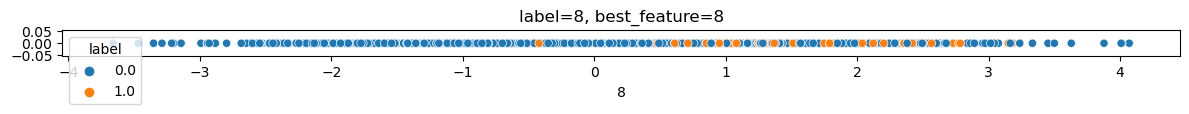

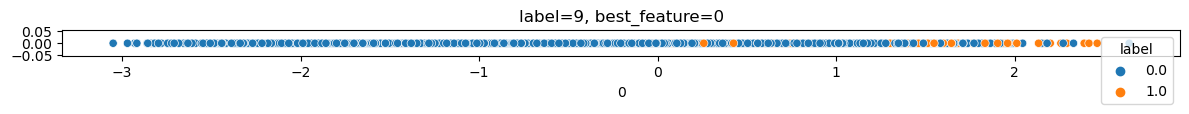

In [11]:
# Decision tree-based feature ranking: plot of best_feature vs rest

for label, best_features in fdr_best_features.items():
    y_one_hot = FeatureRanking().convert_to_one_hot(y, label)
    df_temp = pd.DataFrame(data=np.vstack(
        (X_scaled[:, best_features[0]], y_one_hot)).T, columns=[best_features[0], 'label'])
    plt.figure(2, figsize=(12, 1.2))
    sns.scatterplot(data=df_temp, x=df_temp.columns[0], y=[0]*len(df_temp), hue='label', palette='tab10')
    plt.title('label=' + str(label) + ', best_feature=' + str(best_features[0]))
    plt.tight_layout()
    plt.show()

#### Initial comparison: FDR vs decision tree-based feature ranking

* Same top features to classify digits 0, 1, 2, 3, 4, 6
* Different top feature to classify digits 5, 7, 8, 9


## 1.2. Decision Trees 

### 1.2. a) Classifier

In [12]:
from sklearn.tree import DecisionTreeClassifier

class DecisionTree_Classifier:
    
    '''
    Description: fits and predicts decision trees using sklearn. Contains functions fit, predict, score, and get_param.
    Dependencies: DecisionTreeClassifier from sklearn.tree  
    '''
    
    def __init__(self, max_depth, random_state=1):
        self.max_depth = max_depth 
        self.random_state = random_state

    def fit(self, X: pd.DataFrame or np.array, y: pd.Series or np.array):
        X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        y = y.to_numpy() if isinstance(y, pd.Series) else y
        self.model = DecisionTreeClassifier(max_depth=self.max_depth, random_state=self.random_state)
        self.model.fit(X, y)
        
    def predict(self, X: pd.DataFrame or np.array) -> np.array:
        X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        X = X[np.newaxis, :] if X.ndim < 2 else X
        y_pred = self.model.predict(X) 
        return y_pred
    
    def score(self, X: pd.DataFrame or np.array, y=pd.Series or np.array) -> np.array:
        X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        X = X[np.newaxis, :] if X.ndim < 2 else X
        y = y.to_numpy() if isinstance(y, pd.Series) else y
        y_pred = self.predict(X)
        accuracy = (y_pred == y).mean()
        return accuracy
    
    def get_params(self, deep=True):
        return {'max_depth': self.max_depth, 'random_state': self.random_state}    
    

In [13]:
# decision tree: in-sample accuracy
max_depth=10  # user input
for label in np.unique(y):
    y_one_hot = FeatureRanking().convert_to_one_hot(y, label)
    model = DecisionTree_Classifier(max_depth=max_depth)
    model.fit(X_scaled, y_one_hot)
    y_pred = model.predict(X_scaled)
    accuracy = (y_pred == y_one_hot).mean()
    print(f'label={label}: in-sample accuracy={accuracy:0.4f}')

label=0: in-sample accuracy=0.9930
label=1: in-sample accuracy=0.9986
label=2: in-sample accuracy=0.9928
label=3: in-sample accuracy=0.9940
label=4: in-sample accuracy=0.9948
label=5: in-sample accuracy=0.9798
label=6: in-sample accuracy=0.9980
label=7: in-sample accuracy=0.9968
label=8: in-sample accuracy=0.9884
label=9: in-sample accuracy=0.9942


### 1.2. b) 5-fold cross validation

In [14]:
# hypertune decision tree parameter max_depth for each class, using 5-fold CV, print out-of-sample accuracy

largest_depth = 10  # user input

dict_best_depth = {}
for label in np.unique(y):
    y_one_hot =  FeatureRanking().convert_to_one_hot(y, label)
    
    dict_accuracy_per_depth = {}
    # iterate over all depths from 1 to max_depth
    for max_depth in range(1, largest_depth+1):
        model = DecisionTree_Classifier(max_depth=max_depth)
        cv = KFold(n_splits=5, shuffle=True, random_state=1)
        scores = cross_val_score(model, X_scaled, y_one_hot, cv=cv)
        # print(scores)
        dict_accuracy_per_depth[max_depth] = np.mean(scores)
    
    best_depth = max([k for k, v in dict_accuracy_per_depth.items()
                      if v == max(dict_accuracy_per_depth.values())])
    # dictionary source: https://stackoverflow.com/questions/268272/getting-key-with-maximum-value-in-dictionary
    print(f'label={label}, best_depth={best_depth}, 5-fold CV avg out-of-sample accuracy={dict_accuracy_per_depth[best_depth]:0.4f}')

    dict_best_depth[label] = best_depth

label=0, best_depth=7, 5-fold CV avg out-of-sample accuracy=0.9738
label=1, best_depth=8, 5-fold CV avg out-of-sample accuracy=0.9816
label=2, best_depth=5, 5-fold CV avg out-of-sample accuracy=0.9574
label=3, best_depth=8, 5-fold CV avg out-of-sample accuracy=0.9552
label=4, best_depth=7, 5-fold CV avg out-of-sample accuracy=0.9560
label=5, best_depth=7, 5-fold CV avg out-of-sample accuracy=0.9382
label=6, best_depth=7, 5-fold CV avg out-of-sample accuracy=0.9700
label=7, best_depth=6, 5-fold CV avg out-of-sample accuracy=0.9634
label=8, best_depth=7, 5-fold CV avg out-of-sample accuracy=0.9436
label=9, best_depth=6, 5-fold CV avg out-of-sample accuracy=0.9420


In [15]:
# hypertune decision tree parameter max_depth for each class, using 5-fold CV, print out-of-sample accuracy

largest_depth = 10  # user input

dict_best_depth = {}
for label in np.unique(y):
    y_one_hot =  FeatureRanking().convert_to_one_hot(y, label)
    
    dict_accuracy = {}
    # iterate over all depths from 1 to max_depth
    for max_depth in range(1, largest_depth+1):
        model = DecisionTree_Classifier(max_depth=max_depth)
        cv = KFold(n_splits=5, shuffle=True, random_state=1)
        scores = cross_val_score(model, X_scaled, y_one_hot, cv=cv)
        # print(scores)
        dict_accuracy[max_depth] = np.mean(scores)
    
    best_depth = max([k for k, v in dict_accuracy.items()
                      if v == max(dict_accuracy.values())])
    # dictionary source: https://stackoverflow.com/questions/268272/getting-key-with-maximum-value-in-dictionary
    print(f'label={label}, best_depth={best_depth}, 5-fold CV avg out-of-sample accuracy={dict_accuracy[best_depth]:0.4f}')

    dict_best_depth[label] = best_depth

label=0, best_depth=7, 5-fold CV avg out-of-sample accuracy=0.9738
label=1, best_depth=8, 5-fold CV avg out-of-sample accuracy=0.9816
label=2, best_depth=5, 5-fold CV avg out-of-sample accuracy=0.9574
label=3, best_depth=8, 5-fold CV avg out-of-sample accuracy=0.9552
label=4, best_depth=7, 5-fold CV avg out-of-sample accuracy=0.9560
label=5, best_depth=7, 5-fold CV avg out-of-sample accuracy=0.9382
label=6, best_depth=7, 5-fold CV avg out-of-sample accuracy=0.9700
label=7, best_depth=6, 5-fold CV avg out-of-sample accuracy=0.9634
label=8, best_depth=7, 5-fold CV avg out-of-sample accuracy=0.9436
label=9, best_depth=6, 5-fold CV avg out-of-sample accuracy=0.9420


### 1.2. c) Feature importance

#### Definition 
* Feature importance is a measure of how much each feature contributes to increasing the purity of the nodes in a tree. It is normalised so that the total adds up to 100%. Source: https://towardsdatascience.com/understanding-feature-importance-and-how-to-implement-it-in-python-ff0287b20285

In [16]:
# recap: dictionary of best max_depth for each digit, from 1.2 b)
dict_best_depth

{0: 7, 1: 8, 2: 5, 3: 8, 4: 7, 5: 7, 6: 7, 7: 6, 8: 7, 9: 6}

Label= 0   best_max_depth= 7   top10 features= [20, 0, 40, 2, 44, 41, 43, 42, 22, 58]


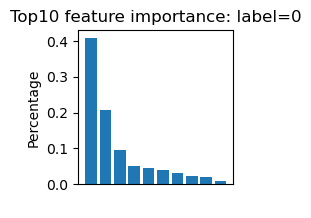

Label= 1   best_max_depth= 8   top10 features= [20, 1, 3, 0, 8, 27, 21, 43, 45, 57]


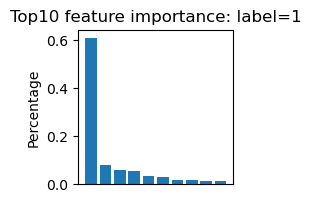

Label= 2   best_max_depth= 5   top10 features= [1, 40, 42, 4, 51, 6, 9, 0, 20, 44]


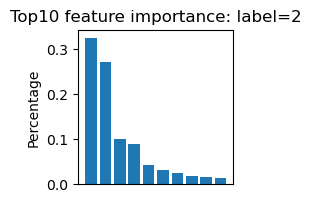

Label= 3   best_max_depth= 8   top10 features= [42, 43, 0, 20, 11, 8, 9, 1, 17, 2]


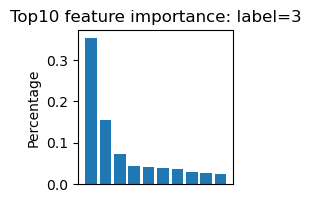

Label= 4   best_max_depth= 7   top10 features= [0, 2, 6, 3, 14, 1, 8, 47, 23, 36]


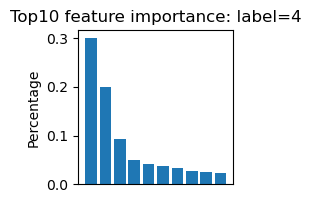

Label= 5   best_max_depth= 7   top10 features= [5, 8, 6, 0, 40, 1, 11, 17, 26, 3]


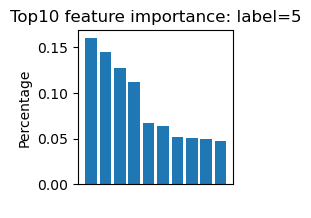

Label= 6   best_max_depth= 7   top10 features= [1, 42, 2, 6, 44, 4, 3, 25, 16, 30]


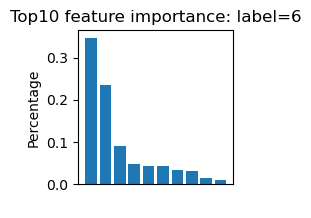

Label= 7   best_max_depth= 6   top10 features= [2, 43, 1, 0, 4, 22, 47, 10, 46, 27]


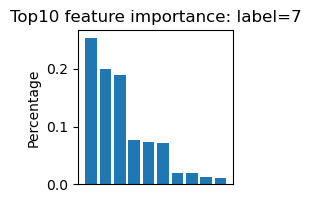

Label= 8   best_max_depth= 7   top10 features= [40, 0, 8, 1, 43, 56, 53, 20, 58, 29]


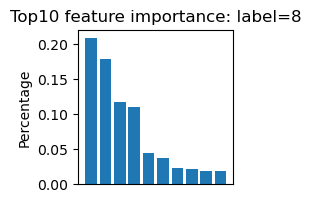

Label= 9   best_max_depth= 6   top10 features= [2, 1, 0, 15, 10, 19, 6, 21, 48, 5]


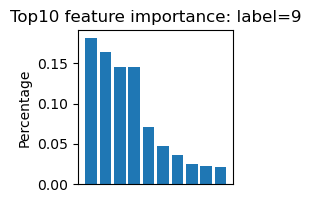

In [17]:
# print and plot top_n feature importances

top_n = 10 

for label, best_depth in dict_best_depth.items():
    y_one_hot = FeatureRanking().convert_to_one_hot(y, label)
    # note: this model is based sklearn directly to be able to extract feature importance
    model = DecisionTreeClassifier(max_depth=best_depth)  
    model.fit(X_scaled, y_one_hot)
    best_features_tree = {}
    for feature, feature_importance in zip(range(X.shape[0]), model.feature_importances_):
        best_features_tree[feature] = round(feature_importance, 4)
    best_features_tree = dict(sorted(best_features_tree.items(), key=lambda item: item[1], reverse=True))
    print('Label=', label, '  best_max_depth=', best_depth,
          '  top10 features=', list(best_features_tree.keys())[:top_n])

    top_n_pct = list(best_features_tree.values())[:top_n]
    plt.figure(figsize=(2,2))
    plt.bar(range(1, len(top_n_pct)+1), top_n_pct)
    plt.title('Top' + str(top_n) + ' feature importance: label=' + str(label))
    plt.ylabel('Percentage')
    plt.tick_params(axis='x', which='both', colors='white')
    plt.show()

### 1.2. d) Unit testing

#### Unit test setup

* For the unit tests, I used the iris dataset, which we analysed in PA1 and understand well.
* Recap: feature ranking, best to worst: ['petal_width', 'petal_length', 'sepal_length', 'sepal_width'].

Unit test #1: 2 features, 2 classes
* Pass best ('petal_width') and worst ('sepal_width') feature as a list of integers [0, 1], where 'petal_width'=0, 'sepal_width'=1.
* Expecting FDR and decision tree-based feature ranking algorithms to return [0, 1] (ranked in descending order) to pass this unit test.

Unit test #2: 3 features, 3 classes
* Best feature ('petal_width') excluded. Features passed: ['petal_length', 'sepal_length', 'sepal_width']. Passed as list of integers, [0,1,2], where 'petal_length'=0, 'sepal_length'=1, 'sepal_width'=2. 
* Expecting FDR and decision tree-based feature ranking algorithms to return [0, 1, 2] (ranked in descending order) to pass this unit test.


In [18]:
# import iris data
df0 = pd.read_csv('iris.csv')

In [19]:
# threshold classifier, for verification

def find_best_threshold(X: np.array or pd.Dataframe, y: np.array or pd.Series):

    # input: data in X, integer labels in y; integer labels starting from 0, in ascending order
    # output: returns a dict with value=(best thresholds, lowest misclassification) for key=feature
        
    X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
    y = y.to_numpy() if isinstance(y, pd.Series) else y 
    
    n_features = X.shape[1]
    n_thresholds = len(np.unique(y))-1  
    best_thresholds = dict()

    for feature in range(n_features):
        feature_values = np.sort(np.unique(X[:, feature]))  # unique array of feature measurments 
        lowest_misclassified = np.inf  # initialise
        best_threshold = None  # initialise
        
        for threshold in combinations(feature_values, n_thresholds): 
            y_pred = np.zeros(y.shape).astype(int)
            
            for i in range(len(threshold)):      
                y_pred[X[:, feature] >= threshold[i]] = i+1
            
            misclassified = np.sum(y_pred!=y)
            if misclassified < lowest_misclassified:
                lowest_misclassified = misclassified
                best_threshold = threshold
        
        best_thresholds[feature] = (best_threshold, lowest_misclassified)
    
    return best_thresholds

In [20]:
# Recap PA1: best feature ranking based on a threshold classifier

features = ['petal_width', 'petal_length', 'sepal_length', 'sepal_width']
species_map = {'setosa': 0, 'versicolor': 1, 'virginica': 2} 

df = df0.replace(species_map)
X = df[features].to_numpy()
y = df.iloc[:, -1].to_numpy()

best_threshold0 = find_best_threshold(X, y)    
for k, v in best_threshold0.items():
    print(f'feature={k}, threshold={np.round(v[0], 2)}, misclassifications={v[1]}')

feature=0, threshold=[1.  1.7], misclassifications=6
feature=1, threshold=[3.  4.8], misclassifications=7
feature=2, threshold=[5.5 6.2], misclassifications=38
feature=3, threshold=[2. 3.], misclassifications=87


#### Unit test #1: 2 classes, 2 features

feature=0, threshold=[1.], misclassifications=0
feature=1, threshold=[5.5], misclassifications=12


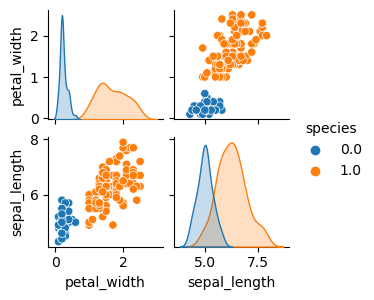

In [21]:
# running threshold classifier, for validation of expected outcome:
# feature 0 'petal_width' is better (fewer misclassifications) than feature 1 'sepal_length'.

features = ['petal_width', 'sepal_length']  # user input 
species_map = {'setosa': 0, 'versicolor': 1, 'virginica': 1} 

df = df0.replace(species_map)
X = df[features].to_numpy()
y = df.iloc[:, -1].to_numpy()

best_threshold = find_best_threshold(X, y)    
for k, v in best_threshold.items():
    print(f'feature={k}, threshold={np.round(v[0], 2)}, misclassifications={v[1]}')

df1 = pd.DataFrame(data=np.concatenate((X, y[:, np.newaxis]), axis=1), columns=features + ['species'])
sns.pairplot(df1, hue='species', palette='tab10', height=1.5)
plt.show()

In [22]:
# unit test #1: FDR
ranking = FeatureRanking()
best_features = ranking.fdr_best_features(X, y)
for k, v in best_features.items():
    print(f'label={k}, best_features={v}')

label=0, best_features=[0, 1]
label=1, best_features=[0, 1]


In [23]:
# unit test #1: decision tree
ranking = FeatureRanking()
best_features = ranking.tree_best_features(X, y, max_depth=4)
for k, v in best_features.items():
    print(f'label={k}, best_features={v}')

label=0, best_features=[0, 1]
label=1, best_features=[0, 1]


#### Conclusions: Unit test #1
* Both FDR and decision tree-based feature ranking algorithms ranked the features correctly: [0, 1]

#### Unit test #2: 3 classes, 3 features

feature=0, threshold=[3.  4.8], misclassifications=7
feature=1, threshold=[5.5 6.2], misclassifications=38
feature=2, threshold=[2. 3.], misclassifications=87


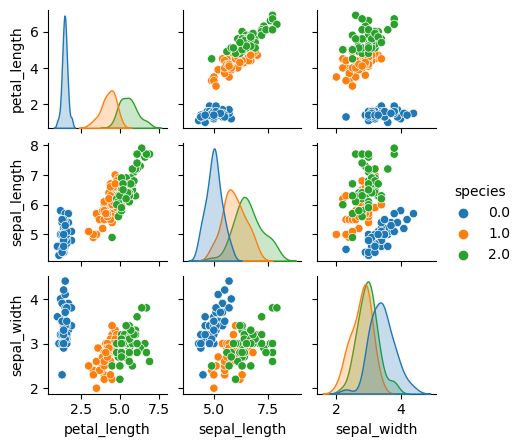

In [24]:
# running threshold classifier, for validation of expected outcome:
# feature 0 > feature 1 > feature 2 (i.e. feature 0 has the lowest number of misclassifications)

features = ['petal_length', 'sepal_length', 'sepal_width'] # user input
species_map = {'setosa': 0, 'versicolor': 1, 'virginica': 2} 

df = df0.replace(species_map)
X = df[features].to_numpy()
y = df.iloc[:, -1].to_numpy()

best_threshold = find_best_threshold(X, y)    
for k, v in best_threshold.items():
    print(f'feature={k}, threshold={np.round(v[0], 2)}, misclassifications={v[1]}')

df1 = pd.DataFrame(data=np.concatenate((X, y[:, np.newaxis]), axis=1), columns=features + ['species'])
sns.pairplot(df1, hue='species', palette='tab10', height=1.5)
plt.show()

In [25]:
# unit test #2: FDR
ranking = FeatureRanking()
best_features = ranking.fdr_best_features(X, y)
for k, v in best_features.items():
    print(f'label={k}, best_features={v}')

label=0, best_features=[0, 1, 2]
label=1, best_features=[2, 0, 1]
label=2, best_features=[0, 1, 2]


In [26]:
# unit test #2: decision tree
ranking = FeatureRanking()
best_features = ranking.tree_best_features(X, y, max_depth=4)
for k, v in best_features.items():
    print(f'label={k}, best_features={v}')

label=0, best_features=[0, 1, 2]
label=1, best_features=[0, 1, 2]
label=2, best_features=[0, 1, 2]


#### Conclusions: Unit test #2 
* Decision-tree ranked all features correctly: [0, 1, 2]
* FDR ranked the features correctly for setosa (one-hot class=0) and viginica (one-hot class=2), but failed to correctly rank the features for versicolour (one-hot class=1).

#### Analysis: Unit test #2
* FDR does not work well with one-hot encoding where the data of the 'hot' class is near the centre and the other datapoints are located symetrically around the centre  so that the mean of these datapoints is also located near the centre, which likely results in an inaccruate outcome.

### 1.2. e-1) Plot decision tree

In [27]:
# re-import dataset
X = pd.read_csv('mnist_60feat.csv', header=None)
y = pd.read_csv('train.csv').iloc[:X.shape[0], 0]

# convert to np.arrays
X = X.to_numpy()
y = y.to_numpy()
assert X.shape ==  (5000, 60) and y.shape == (5000,)

In [28]:
label=0  # user input; change to plot the tree of a different class

y_one_hot = FeatureRanking().convert_to_one_hot(y, label)
# create tree with best max_depth from 2.b) 5-fold CV
model = DecisionTreeClassifier(max_depth=dict_best_depth[label])
model.fit(X_scaled, y_one_hot)

DecisionTreeClassifier(max_depth=7)

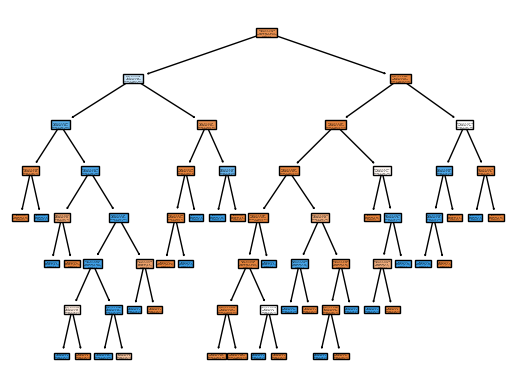

In [29]:
# plot entire tree
tree.plot_tree(model, class_names=[str(i) for i in np.unique(y)], filled=True)
plt.show()

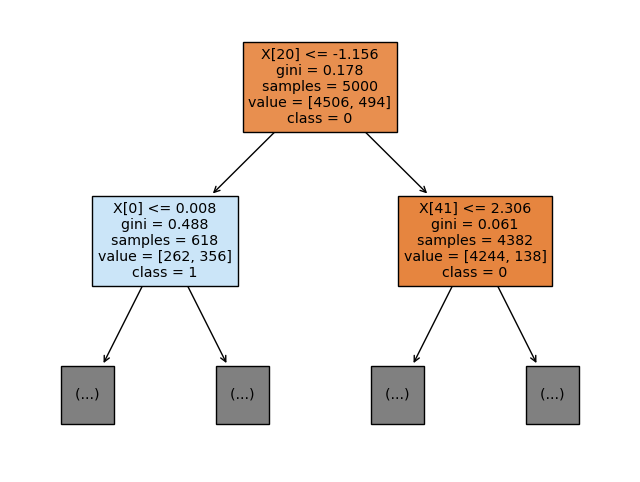

In [30]:
# zooming in on the first 2 levels
plt.figure(figsize=(8,6))
class_names = [str(i) for i in np.unique(y)]
tree.plot_tree(model, max_depth=1, class_names=class_names, filled=True)
plt.show()

#### Key parameters displayed
* The tree above depicts level 0 and level 1 of the full tree. 
* Each node contains 5 items:
  1. Decision rule, eg X[20] <= 1.156. The left and right child nodes contain all samples for which this condition is true and false, respectively.
  2. Gini impurity, ranging from 0 to 1. A lower value indicates more homogeneous (purer) subsets after a split, which is more desirable. Source: https://towardsdatascience.com/decision-trees-explained-entropy-information-gain-gini-index-ccp-pruning-4d78070db36c
  3. Total number of samples at the current node, before the next split.
  4. Number of samples in each 'bucket' (eg X[20] <= or >1.156) at the current node , before the next split.
  5. Class majority: the last item returns the class with the highest count (majority class).

### 1.2. e-2) Analysis: Training & Runtime Complexity

* Decision trees are built by recursively splitting training samples using features from the data that result in the highest purity (Gini index) at the next level ie the node's child nodes. 
* At each level, n_samples * n_feature are considered, and a balanced binary tree has a maximum depth equal to the log of the number of samples. Sources: https://towardsdatascience.com/decision-trees-explained-3ec41632ceb6#:~:text=At%20each%20node%20a%20variable,that%20best%20splits%20the%20data, and https://www.cs.cornell.edu/courses/JavaAndDS/files/tree3binaryTreeHeight.pdf.
* The total run time is therefore O(n_samples * n_features * log_2(n_samples), as discussed in the sklearn documentation on decision trees, section 1.10.4. on complexity: https://scikit-learn.org/stable/modules/tree.html.



### 1.2. f) Analysis: FDR vs Decision Trees

* We have seen that FDR-based feature ranking does not work with one-vs-all, particularly where the data of the 'hot' class is near the centre and the other datapoints are located symmetrically around the centre so that the mean of these datapoints is also located near the centre, which likely results in an inaccurate outcome.
* FDR-based feature ranking can be used to 1) rank features of datasets with two classes, 2) one-vs-all where the 'hot' class is on the edge of the dataset so that the means of the 'hot' class and the mean of the other datapoints do not overlap, or 3) for one-vs-one binary classifications (in the case of the MNIST database this would require training n!/r!(n-r)!=45 separate models). 
* FDR-based feature ranking is easier to understand and to check that decision tree-based feature ranking. Where possible (i.e. in the 3 cases described), my preference would be to use FDR.  
* Decision tree-based feature ranking: we have seen during unit testing that decision trees do not suffer from the limitations of FDR and are the preferrable choice for a multi-class one-vs-all approach. However, there are more difficult to understand and check (for example, unit testing with the iris dataset was straightforward, unit testing with the MNIST dataset would have been much more involved).

# Question 2 - Machine Learning

## 2.1. Preprocessing

In [31]:
class Preprocessing:
    
    '''
    Preprocessing contains the following functions:
    - standarise_data
    - normalise_data
    - remove_outliers_md
    - feature_selection_pca
    - transform_data_pca
    - feature_selection_fdr
    - feature_selection_tree
    '''
    
    def __init__(self):
        pass    
         
    def standardise_data(self, X: pd.DataFrame or np.array, X_mean=None, X_std=None) -> np.array:
        # requires data in rows=observations, columns=features format
        # returns z-scores
        X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        X_mean = np.mean(X, axis=0) if X_mean is None else X_mean  # for X_test, use mean/std from X_train
        X_std = np.std(X, axis=0) if X_std is None else X_std
        return (X - X_mean) / X_std
    
        # Note: code for built-in scaler
        # from sklearn.preprocessing import StandardScaler
        # scaler = StandardScaler().fit(X_train)
        # X_train_scaled = scaler.transform(X_train)
        # X_test_scaled = scaler.transform(X_test)

    def normalise_data(self, X: pd.DataFrame or np.array, X_min=None, X_max=None) -> np.array:
        # requires data in rows=observations, columns=features format
        # returns scaled values between [0,1]
        X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        X_max = np.max(X, axis=0) if X_max is None else X_max  # for X_test, use min/max from X_train
        X_min = np.min(X, axis=0) if X_min is None else X_min
        return (X - X_min) / (X_max - X_min)

    def remove_outliers_md(self, X0: pd.DataFrame or np.array, y0: np.array or pd.Series,
                           pct_covered=0.99, display=False) -> np.array:
        """
        Description: removes outliers in sequential order up to cutoff stdev, 
        starting with the largest mahalanobis distance
        Input: X=data as np.array or df, pct_covered (=cutoff for outliers), display T/F
        Output: returns a trimmed array X with outlier rows removed  
        """
        
        X, y = X0.copy(), y0.copy()
        X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        y = y.to_numpy() if isinstance(y, pd.Series) else y
        
        def inverted_covariance_matrix(X: np.array):
            # inverted covariance matrix
            if X.shape[1] >1:
                S = np.cov(X, rowvar=False)
                SI = np.linalg.inv(S)
            else:
                SI = np.std(X)   
            return SI

        def mahalanobis_distance(u: np.array, v: np.array, SI: np.array):
            # mahalanobis distance
            # intput: point u, point v (eg centre), inverted covar matrix SI
            md2 = np.dot((u-v).T, np.dot(SI, (u-v)))
            md = np.sqrt(md2)
            return md

        def mahalanobis_distances_from_centre(X: np.array) -> np.array:
            # compute mahalanobis distance of each observation from the centre
            SI = inverted_covariance_matrix(X) 
            centre = np.mean(X, axis=0)
            distances = []
            for i in range(X.shape[0]):
                distance = mahalanobis_distance(X[i, :], centre, SI)
                distances.append(distance)
            return np.array(distances)

        def mahalanobis_cutoff(X, y, pct_covered=pct_covered): 
            # Calculate the Mahalanobis distance cutoff based on a given percent covered.
            # The Mahalanobis distance is defined as: D^2 = (x - μ)^T Σ^(-1) (x - μ)
            # D^2 follows a chi-square distribution with d.f. equal to the dimension of the dataset
            # Dependencies: from scipy.stats.distributions import chi2
            degrees_of_freedom = X.shape[1]
            critical_value = chi2.ppf(pct_covered, df=degrees_of_freedom)
            mahalanobis_distance_cutoff = np.sqrt(critical_value)
            return mahalanobis_distance_cutoff

        # get the mahalanobis cutoff distance based on percentage covered
        cutoff = mahalanobis_cutoff(X, y, pct_covered)
        distances = mahalanobis_distances_from_centre(X)
        outliers = distances > cutoff
        removed_indices = []
        # max_iter = int((1-pct_covered) * X.shape[0])  # can't remove more than defined as outlier threshold 
        count = 0
        while sum(outliers) > 0:
        # while sum(outliers) > 0 and count < max_iter:
            if display: 
                print('cutoff=', round(cutoff, 2), 'max_dist=', round(max(distances), 2),
                  'number of outliers=', sum(outliers), 'removed=', len(removed_indices),
                      'X.shape=', X.shape)
            max_idx=np.argmax(distances)
            removed_indices.append(max_idx)
            X = np.delete(X, max_idx, axis=0)
            y = np.delete(y, max_idx, axis=0)
            distances = mahalanobis_distances_from_centre(X)
            outliers = distances > cutoff
            count += 1
            
        return X, y

    def feature_selection_pca(self, X: pd.DataFrame or np.array, y=None,
                              n_components=4, display=False) -> (np.array, dict):
        
        """
        Description: feature selection/reduction based on principal component analysis.
        Input: X=data as np.array or df, n_components=top nth principal components to be kept, display T/F
        Output: an array X with features reduced to d=n_components.
        Source: modified version of
        https://towardsdatascience.com/principal-component-analysis-pca-from-scratch-in-python-7f3e2a540c51
        """
        
        X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        y = y.to_numpy() if isinstance(y, pd.Series) else y

        # standardise data
        X_mean = np.mean(X, axis=0)
        X_std = np.std(X, axis=0)
        X = (X - X_mean) / X_std

        # get covar matrix
        S = np.cov(X, rowvar=False)

        # get eigenvalues, eigenvectors
        eigvals, eigvecs = np.linalg.eig(S)

        # sort eigenvalues, eigenvectors in descending order
        idx = eigvals.argsort()[::-1]
        eigvals = eigvals[idx]
        eigvecs = eigvecs[:, idx]

        explained_vars = []
        for i in range(len(eigvals)):
            explained_vars.append(eigvals[i] / np.sum(eigvals))
        explained_vars = np.array(explained_vars)

        principal_components = []
        for i in range(n_components):
            principal_component = X @ eigvecs.T[i]
            principal_components.append(principal_component)
        X_pc = np.array(principal_components).T

        if display:
            assert y is not None
            cols = ['pc' + str(i) for i in range(n_components)]
            df_pc = pd.DataFrame(X_pc, columns=cols)
            df_pc['label'] = y

            # pairplot
            # plt.figure(2, figsize=(10, 6))
            # sns.pairplot(data=df_pc, hue='label', palette='tab10')
            # plt.show()

            # explained variance plot
            plt.figure(figsize=(2,2))
            plt.plot(explained_vars)
            plt.title('PCA explained variance')
            plt.show()

        model = {'eigvecs': eigvecs[:, :n_components], 'X_mean': X_mean, 'X_std': X_std}
        
        return X_pc, model
        
    def testdata_transformation_pca(self, X: pd.DataFrame or np.array, model: dict) -> np.array:
        
            X = X.to_numpy() if isinstance(X, pd.DataFrame) else X

            # standardise the data using the mean, std from the training data
            X = (X - model['X_mean']) / model['X_std']

            # project the test data onto the principal components
            X_pc = X @ model['eigvecs']

            return X_pc

    def feature_selection_fdr(self, X: np.array or pd.DataFrame, y: np.array or pd.Series,
                              n_features=4, display=False) -> np.array:
    
        """
        Returns the highest Fisher discriminant ratio for each feature, using a one-vs-all appraoch
        Input: X=data, y=labels as np.array or df 
        Output: an array X that contains the top n_features for each class (duplicates removed)
        Note: only use for 2 classes, or where the one-hot class is near the edge of the featurespace
        """

        X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        y = y.to_numpy() if isinstance(y, pd.Series) else y
        
        # FDR calculation:
        def get_fdr(arr1: np.array, arr2: np.array) -> float:
            mu1, mu2 = np.mean(arr1), np.mean(arr2)
            std1, std2 = np.std(arr1), np.std(arr2)
            fdr = (mu1 - mu2)**2 / (std1**2 + std2**2)
            return fdr        

        # create array of unique features
        labels = np.unique(y)  

        # initialise a dict to store labels (=keys), list of best features, in descending order (=values)
        best_features = {}

        # for each class (label), calculate the fdr between the selected class and all other classes
        for label in labels:
            label_fdrs = []
            for feature in range(X.shape[1]):
                arr1 = X[y==label][:, feature]
                arr2 = X[y!=label][:, feature]
                fdr = get_fdr(arr1, arr2)
                label_fdrs.append(fdr)
            label_fdrs = pd.Series(label_fdrs).sort_values(ascending=False).index.to_list()
            label_fdrs = label_fdrs[:n_features]
            best_features[label] = label_fdrs

        # remove duplicates (if best_feature is best_feature of more than 1 classes) 
        best_features_ = list(set([val for sublist in best_features.values() for val in sublist]))
        X_fdr = X[:, sorted(best_features_)]

        return X_fdr
    
    def feature_selection_tree(self, X: pd.DataFrame or np.array, y: pd.Series or np.array,
                           n_features=10, max_depth=10, random_state=1) -> np.array:

        """
        Description: ranks features based on sklearn's DecisionTree classifier, using a one-vs-all approach.
        Approach: takes the top n_features of each class, then removes duplicates.
        (ie he total number of features kept is smaller or equal to n_features x n_classes)
        Input: X (=data), y (=labels), numpy arrays or df.
        Output: an array with the top n_features per class, with overlaps removed.
        """
        
        X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        y = y.to_numpy() if isinstance(y, pd.Series) else y
        
        # create array of unique features
        labels = np.unique(y)  
        
        # initialise a dict to store labels (=keys), list of best features, in descending order (=values)
        best_features = []
        
        # 
        for label in labels:
            y_one_hot = y.copy()
            y_one_hot[y==label] = 1
            y_one_hot[y!=label] = 0
            model = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)
            model.fit(X, y_one_hot)    
            best_features.extend(pd.Series(model.feature_importances_).sort_values(ascending=False).index.to_list()[:n_features])
        
        best_features = np.unique(np.array(best_features))
        
        return X[:, best_features], best_features 
    

#### Preprocessing approach

* FDR-based feature reduction: one-vs-all FDR appraoch not suitable for multi-class data, as discussed in Problem 1.
* PCA-based feature reduction: a possible way to reduce the dimension of the dataset. 
* Decision tree-based feature reduction: another possible way to reduce the dimension of the dataset.
* Mahalanobis distance-based outlier removal: emperical evidence from my work on the MNIST dataset suggests that outlier removal doesn't work well on high-dimensional data if applied before feature reduction, but can be effective if used after PCA or tree-based feature reduction. 
* Following trial and error , I have decided on the following preprocessing pipeline:

#### Preprocessing pipeline
  1. Standardise data (normalisation also works for KernelSVM but cannot be used for ParzenWindows; my goal was to use a pipeline that works for all 3 classifiers)
  2. Decision-tree based feature reduction (PCA-based feature reduction results in a similar performance/accuracy, conceptually I perfer to use decision tree based feature reduction over PCA since PCA was already used in HW3 to generate the raw data for this assignment).
  3. Mahalanobis distance-based outlier removal


In [32]:
# import and prep data

# user input
n_fold = 5
holdout_pct = 0.2
n_components = 20  # PCA-based feature reduction: keeps top n principal components
n_features = 6     # tree-based feature reduction: keeps top n features for each class, with overlapping features removed.
pct_covered = 0.99 # mahalanobis outlier removal: keeps data within cutoff corresponding to pct_covered

# import dataset
X = pd.read_csv('mnist_60feat.csv', header=None)
y = pd.read_csv('train.csv').iloc[:X.shape[0], 0]

# convert to np.array
X, y = X.to_numpy(), y.to_numpy()

# split data into train-test(holdout)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=holdout_pct, random_state=0)

# prep X_train
prep = Preprocessing()
X_mean, X_std = np.mean(X_train, axis=0), np.std(X_train, axis=0)
X_train = prep.standardise_data(X_train, X_mean, X_std)
# X_train, pca_model = prep.feature_selection_pca(X_train, y_train, n_components=n_components, display=True)
X_train, best_features = prep.feature_selection_tree(X_train, y_train, n_features=n_features)
X_train, y_train = prep.remove_outliers_md(X_train, y_train, pct_covered=pct_covered, display=False)

# prep X_test based on X_train
X_test = prep.standardise_data(X_test, X_mean, X_std)
# X_test = prep.testdata_transformation_pca(X_test, pca_model)
X_test = X_test[:, best_features]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(3123, 24) (3123,) (1000, 24) (1000,)


## 2.2. Classification

#### Classification pipeline
1. Split into X_train, X_test (=hold-out dataset)
2. Find best hyperparameters using 5-fold CV on X_train (X_train is split into 5 X_train, X_test sets - not to be confused with hold-out X_test from 1.)
3. Fit model based on hyperparameters with the highest accruacy from 5-fold CV
4. Compute out-of-sample accuracy from hold-out data X_test from 1.)

In [50]:
# general outline of the 3 classifiers 

class XZY_Classifier:
    
    def __init__(self, param):
        self.param = param       

    def fit(self, X: pd.DataFrame or np.array, y: pd.Series or np.array):
        
        X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        y = y.to_numpy() if isinstance(y, pd.Series) else y
        
        return self

    def predict(self, X: pd.DataFrame or np.array) -> np.array:
        
        X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        X = X[np.newaxis, :] if X.ndim < 2 else X
        
        y_pred = None  
        
        return y_pred

    def score(self, X: pd.DataFrame or np.array, y=pd.Series or np.array) -> np.array:

        X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        X = X[np.newaxis, :] if X.ndim < 2 else X
        y = y.to_numpy() if isinstance(y, pd.Series) else y

        y_pred = self.predict(X)
        accuracy = (y_pred == y).mean()
        
        return accuracy
    
    def get_params(self, deep=True):
        
        return {'param': self.param}    
    

In [34]:
class Bayes_Classifier:
    
    def __init__(self):
        pass  

    def fit(self, X: pd.DataFrame or np.array, y: pd.Series or np.array):
        # computes and stores the following attributes: mean array, covar matrix, prior array
        
        X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        y = y.to_numpy() if isinstance(y, pd.Series) else y 
        
        self.dim = X.shape[1]
        self.labels = np.sort(np.unique(y))
        
        means = []
        covars = []
        priors = []
        for label in self.labels:
            X_class = X[y==label]
            means.append(np.mean(X_class, axis=0))
            covars.append(np.cov(X_class, rowvar=False))
            priors.append(len(y[y==label]))
        self.means = np.array(means)
        self.covars = np.array(covars)
        self.priors = np.array(priors)/np.sum(np.array(priors))
        return self
        
    def predict(self, X: pd.DataFrame or np.array) -> np.array:
        # predicts labels based on highest Bayesian probability.
        # equations based on MachineLearning.pdf (JHU EN.685.621 Module 8, ML)
        
        X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        X = X[np.newaxis, :] if X.ndim < 2 else X
        
        y_pred = []
        for i in range(X.shape[0]):
            x0=X[i, :]
            cond_prob = []
            for label in self.labels:
                norm_factor = 1/np.sqrt((2*np.pi)**self.dim * np.abs(np.linalg.det(self.covars[label])))
                exponential = np.exp(-1/2*(x0-self.means[label]).T @ np.linalg.inv(self.covars[label]) @ (x0-self.means[label]))
                cond_prob.append(self.priors[label] * norm_factor * exponential)
            y_pred.append(np.argmax(np.array(cond_prob)))
        self.y_pred = np.array(y_pred)
        return self.y_pred

    def score(self, X: pd.DataFrame or np.array, y=pd.Series or np.array) -> np.array:
        
        X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        X = X[np.newaxis, :] if X.ndim < 2 else X
        y = y.to_numpy() if isinstance(y, pd.Series) else y
        
        # predict y
        y_pred = self.predict(X)
        
        # compute accuracy
        accuracy = (y_pred == y).mean()
        
        return accuracy
    
    
    def get_params(self, deep=True):
        # necessary function to be able to use classifier together with sklearn's cross val module
        return {}

In [35]:
class ParzenWindow_Classifier:
    
    def __init__(self, h=None):
        self.h = h

        
    def fit(self, X: pd.DataFrame or np.array, y: pd.Series or np.array):
        #  stores the following attributes: X_train, y_train, unique list of labels, dimension, hyperparam h
        
        self.X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        self.y = y.to_numpy() if isinstance(y, pd.Series) else y 
        
        self.labels = np.sort(np.unique(self.y))
        self.dim = self.X.shape[1]
        self.h = 1/np.sqrt(self.X.shape[0]) if self.h is None else self.h 
        
        return self
        
    def predict(self, X: pd.DataFrame or np.array) -> np.array:
        # predicts labels based on Parzen Windows (highest count of class labels within window)
        # equations based on MachineLearning.pdf (JHU EN.685.621 Module 8, ML)
        
        X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        X = X[np.newaxis, :] if X.ndim < 2 else X
        
        y_pred = []
        for i in range(X.shape[0]):
            x0 = X[i, :]
            cond_prob = []
            for label in self.labels:
                X_class = self.X[self.y==label]   ### check; print tables
                n = X_class.shape[0]
                total = 0
                for j in range(n):
                    x = X_class[j, :]
                    norm_sq = np.dot((x0-x), (x0-x))
                    total += np.exp(-norm_sq/(2*self.h**2))                    
                norm_factor = 1/(np.sqrt(2*np.pi))**self.dim/self.h**self.dim  
                cond_prob.append(1/n * norm_factor * total)
            y_pred.append(np.argmax(np.array(cond_prob)))      
        y_pred = np.array(y_pred) 
        
        return y_pred


    def score(self, X: pd.DataFrame or np.array, y=pd.Series or np.array) -> np.array:
        
        X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        X = X[np.newaxis, :] if X.ndim < 2 else X
        y = y.to_numpy() if isinstance(y, pd.Series) else y
        
        # predict y
        y_pred = self.predict(X)
        
        # compute accuracy
        accuracy = (y_pred == y).mean()
        
        return accuracy


    def get_params(self, deep=True):
        # necessary function to be able to use classifier together with sklearn's cross val module
        return {'h': self.h}
  

In [ ]:
class KernelSVM_Classifier:
  
    def __init__(self, kernel='rbf', gamma=0.1, C=10):
        self.kernel = kernel
        self.gamma = gamma  # kernel rbf: width of Gaussian function
        self.C = C  # soft margin regularisation parameter, regularises the trade-off between
        # maximising the margin and minimising classification errors (points on the wrong side).

    def get_kernel(self, X1, X2):
        if self.kernel == 'linear':
            K = X1 @ X2.T
        elif self.kernel == 'rbf':
            K = np.exp(-self.gamma*((np.linalg.norm(X1[:, np.newaxis]-X2, axis=2))**2))
        else:
            raise ValueError('kernel type not available')
        return K

    def fit(self, X, y):
        # equations based on MachineLearning.pdf, kernelSVM.m, trainSVM.m, and classifySVM.m
        # (JHU EN.685.621 Module 8, ML)
    
        self.models = dict()
        n_samples, n_features = X.shape
        labels = np.sort(np.unique(y))
        Y_1hot = self.convert_to_one_hot(y)

        for i in range(len(labels)):
        
            y = Y_1hot[:, i]
            label = labels[i]
            self.models[label] = dict() 
                       
            K = self.get_kernel(X, X)
            H = np.outer(y, y) * K

            mu = 1e-12
            eps = 1e-12
            
            # add a small positive constant to the diagonal to ensure H is invertible
            H += np.eye(K.shape[0]) * mu
            
            # create matrices required for cvxopt
            P = matrix(H)
            q = matrix(-np.ones(n_samples))
            G = matrix(np.vstack((np.eye(n_samples) * -1, np.eye(n_samples))))
            h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C)))
            A = matrix(y.reshape(1, -1), tc='d')
            b = matrix(np.zeros(1))

            options = {  # cvxopt documentation: https://cvxopt.org/userguide/solvers.html#options
                'maxiters': 50,         # max number of iterations, default = 100
                'feastol': 1e-5,        # feasibility tolerance, default = 1e-7
                'abstol': 1e-5,         # absolute optimality tolerance, default = 1e-7
                'reltol': 1e-5,         # relative optimality tolerance, default = 1e-6
                'show_progress': False}
            
            # solve for coefficients alpha, the importance or weight of each datapoint
            optimiser = solvers.qp(P, q, G, h, A, b, options=options)
            alphas = np.array(optimiser['x']).flatten()

            # store optimiser output for predictions
            S = (alphas > eps)
            self.models[label]['support_vectors'] = X[S]
            self.models[label]['support_alphas'] = alphas[S]
            self.models[label]['support_labels'] = y[S]
            self.models[label]['bias'] = np.mean(
                self.models[label]['support_labels'] - np.sum(
                    self.models[label]['support_alphas'] * self.models[label]['support_labels'] * self.get_kernel(
                        self.models[label]['support_vectors'], self.models[label]['support_vectors']), axis=1))
                       
        return self

    def predict(self, X):
        # equations based on MachineLearning.pdf, kernelSVM.m, trainSVM.m, and classifySVM.m
        # (JHU EN.685.621 Module 8, ML)
     
        Y_pred = []
        for label in self.models.keys():
            K = self.get_kernel(X, self.models[label]['support_vectors'])
            y_pred_raw = K @ (self.models[label]['support_alphas'] * self.models[label]['support_labels']) + self.models[label]['bias']
            # y_pred = np.sign(y_pred_raw)  # switch to binary output, +1/-1 based on sign of y_pred    
            Y_pred.append(y_pred_raw)

        Y_pred = np.array(Y_pred).T
        y_pred = np.argmax(Y_pred, axis=1)

        return y_pred

    def score(self, X: pd.DataFrame or np.array, y=pd.Series or np.array) -> np.array:
        
        X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        X = X[np.newaxis, :] if X.ndim < 2 else X  # converts single datapoints into required shape
        y = y.to_numpy() if isinstance(y, pd.Series) else y
        
        # predict y
        y_pred = self.predict(X)
        
        # compute accuracy
        accuracy = (y_pred == y).mean()
        
        return accuracy

    def get_params(self, deep=True):
        # necessary function to be able to use classifier together with sklearn's cross val module
       
        return {'kernel': self.kernel, 'gamma': self.gamma, 'C': self.C}
    
    def convert_to_one_hot(self, y: pd.Series or np.array) -> np.array:
        # Input: a n x 1 array of integer labels, with k classes
        # Output: a n x k array Y_one_hot
        
        y = pd.Series(y) if not isinstance(y, pd.Series) else y

        n_classes = len(y.unique())
        Y_1hot = np.zeros((y.shape[0], n_classes))
        for i in range(n_classes):
            one_hot_map = {}
            for j in range(n_classes):
                one_hot_map[j] = 1 if i == j else -1
            Y_1hot[:, i] = y.replace(one_hot_map).to_numpy()

        return Y_1hot


In [37]:
# train Bayes
model = Bayes_Classifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
accuracy = (y_pred == y_train).mean()
print(f'Bayes: in-sample accuracy={accuracy:0.4f}')

Bayes: in-sample accuracy=0.9664


In [38]:
# train ParzenWindow
model = ParzenWindow_Classifier(h=0.5)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
accuracy = (y_pred == y_train).mean()
print(f'ParzenWindow: in-sample accuracy={accuracy:0.4f}')

ParzenWindow: in-sample accuracy=1.0000


In [39]:
# train KernelSVM  
model = KernelSVM_Classifier('rbf', gamma=0.1, C=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
accuracy = (y_pred == y_train).mean()
print(f'KernelSVM: in-sample accuracy={accuracy:0.4f}')

KernelSVM: in-sample accuracy=1.0000


## 2.3. Cross-validation

Metrics
* Accuracy: % of labels classified correctly.
* Precision: measures how many of the positive predictions are positives.
* Recall: how many of the actual positives are correctly identified as positives.

In [40]:
# Bayes: train model, compute out-of-sample accuracy

# cross validation
print('Bayes Classifier\n')
model = Bayes_Classifier()
cv = KFold(n_splits=n_fold, shuffle=True, random_state=1)
scores = cross_val_score(model, X_train, y_train, cv=cv)
print(f'{n_fold}-fold CV avg score={np.mean(scores):0.4f}')
    
# out-of-sample accuracy
model = Bayes_Classifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = model.score(X_test, y_test)

print(f'\nOut-of-sample score={np.mean(score):0.4f}')
print('\n', 55*'-' , '\nConfusion matrix\n')
cm = confusion_matrix(y_test, y_pred)
print(cm)

print('\n', 55*'-' , '\nClassification report')
rpt = classification_report(y_test, y_pred, zero_division=False)
print(rpt)

Bayes Classifier

5-fold CV avg score=0.9411

Out-of-sample score=0.9310

 ------------------------------------------------------- 
Confusion matrix

[[100   0   0   1   0   1   0   0   1   0]
 [  0  91   3   0   0   0   0   0   6   0]
 [  0   0 100   0   0   0   0   1   2   1]
 [  0   0   0  95   0   1   0   0   2   2]
 [  0   0   2   0 102   0   0   0   1   2]
 [  0   0   1   3   0  89   1   0   0   0]
 [  1   0   1   0   2   2  86   0   1   0]
 [  0   0   5   2   0   0   0 104   2   3]
 [  0   1   0   1   0   2   0   0  80   1]
 [  2   0   2   2   2   1   0   1   4  84]]

 ------------------------------------------------------- 
Classification report
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       103
           1       0.99      0.91      0.95       100
           2       0.88      0.96      0.92       104
           3       0.91      0.95      0.93       100
           4       0.96      0.95      0.96       107
           5 

In [49]:
# ParzenWindow: train model, find best hyperparameter using CV, compute out-of-sample accuracy

# user input
h_values = np.array([0.1, 0.25, 0.5])  # values based on range provided in HW3

# find best parameter combination based on out-of-sample accuracy from n_fold CV
print('ParzenWindow Classifier\n')
params = {}
for h in h_values:
    model = ParzenWindow_Classifier(h=h)
    cv = KFold(n_splits=n_fold, shuffle=True, random_state=1)
    scores = cross_val_score(model, X_train, y_train, cv=cv)
    params[h] = np.mean(scores)
    print(f'h={h}, {n_fold}-fold CV avg score={np.mean(scores):0.4f}')

# get best params
best_h = max(params, key=params.get)

# out-of-sample accuracy
model = ParzenWindow_Classifier(h=best_h)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = model.score(X_test, y_test)

print(f'\nHypertuned model (h={best_h}): out-of-sample score={np.mean(score):0.4f}')
print('\n', 55*'-' , '\nConfusion matrix\n')
cm = confusion_matrix(y_test, y_pred)
print(cm)

print('\n', 55*'-' , '\nClassification report')
rpt = classification_report(y_test, y_pred, zero_division=False)
print(rpt)


ParzenWindow Classifier

h=0.1, 5-fold CV avg score=0.8995
h=0.25, 5-fold CV avg score=0.9078
h=0.5, 5-fold CV avg score=0.9110

Hypertuned model (h=0.5): out-of-sample score=0.8910

 ------------------------------------------------------- 
Confusion matrix

[[ 94   0   0   1   1   3   1   3   0   0]
 [  0  98   0   0   0   0   1   0   0   1]
 [  1   2  87   1   3   0   0   2   5   3]
 [  0   0   2  87   0   3   0   1   5   2]
 [  0   0   0   0 101   0   1   0   1   4]
 [  1   2   1   4   0  81   2   0   2   1]
 [  3   0   1   0   0   1  88   0   0   0]
 [  0   2   1   1   0   1   1 109   0   1]
 [  0   2   1   3   5   6   1   0  64   3]
 [  3   1   0   0   8   0   0   2   2  82]]

 ------------------------------------------------------- 
Classification report
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       103
           1       0.92      0.98      0.95       100
           2       0.94      0.84      0.88       104
           3

In [48]:
# KernelSVM: train model, find best hyperparameters using CV, compute out-of-sample accuracy

from sklearn.svm import SVC  # using built-in Kernel SVM for hyperparameter tuning only as much faster

# user input
gamma_values = np.array([0.001, 0.01, 0.1])
C_values = np.array([1, 10, 100])
# range of gamma, C is based on the section on hyperparameter tuning in the sklern documentation on SVMs:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#tuning-hyper-parameters

# create parameter grid 
gamma_grid, C_grid = np.meshgrid(gamma_values, C_values)
grid = list(zip(gamma_grid.flatten(), C_grid.flatten()))

# find best parameter combination based on out-of-sample accuracy from n_fold CV
print('KernelSVM Classifier\n')
params = {}
for gamma, C in grid:
    model = SVC(kernel='rbf', gamma=gamma, C=C)  # built-in Kernel SVM (much faster, see 2.4.b runtime analysis)
    # model = KernelSVM_Classifier(kernel='rbf', gamma=gamma, C=C)
    cv = KFold(n_splits=n_fold, shuffle=True, random_state=1)
    scores = cross_val_score(model, X_train, y_train, cv=cv)
    params[(gamma, C)] = np.mean(scores)
    print(f'gamma={gamma}, C={C}, {n_fold}-fold CV avg score={np.mean(scores):0.4f}')

# get best params
best_gamma, best_C = max(params, key=params.get)

# out-of-sample accuracy
model = KernelSVM_Classifier(kernel='rbf', gamma=best_gamma, C=best_C) # self-developed Kernel SVM with best parameters
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = model.score(X_test, y_test)

print(f'\nHypertuned model (gamma={best_gamma}, C={best_C}): out-of-sample score={np.mean(score):0.4f}')
print('\n', 55*'-' , '\nConfusion matrix\n')
cm = confusion_matrix(y_test, y_pred)
print(cm)

print('\n', 55*'-' , '\nClassification report')
rpt = classification_report(y_test, y_pred, zero_division=False)
print(rpt)


KernelSVM Classifier

gamma=0.001, C=1, 5-fold CV avg score=0.8361
gamma=0.01, C=1, 5-fold CV avg score=0.9081
gamma=0.1, C=1, 5-fold CV avg score=0.9481
gamma=0.001, C=10, 5-fold CV avg score=0.8934
gamma=0.01, C=10, 5-fold CV avg score=0.9315
gamma=0.1, C=10, 5-fold CV avg score=0.9516
gamma=0.001, C=100, 5-fold CV avg score=0.9110
gamma=0.01, C=100, 5-fold CV avg score=0.9353
gamma=0.1, C=100, 5-fold CV avg score=0.9516

Hypertuned model (gamma=0.1, C=10): out-of-sample score=0.9330

 ------------------------------------------------------- 
Confusion matrix

[[ 95   0   0   3   0   2   1   2   0   0]
 [  0  96   1   0   0   1   1   0   0   1]
 [  0   0  93   1   0   0   1   2   5   2]
 [  0   0   0  96   0   0   0   1   2   1]
 [  1   0   0   0 105   0   0   0   0   1]
 [  0   0   0   4   0  88   2   0   0   0]
 [  2   0   1   1   0   1  88   0   0   0]
 [  0   1   1   1   2   1   0 109   0   1]
 [  0   1   1   2   1   3   0   0  74   3]
 [  3   0   0   0   4   0   0   1   1  89]]



## 2.4. Analysis

### 2.4. a) Findings

* The preprocessing pipeline, as disucssed in 2.1. together with a hypertuned KernelSVM resulted in the highest out-of-sample (holdout data) accuracy score of 93.3%, closely followed by the Bayesian classifier, which achieved an out-of-sample accuracy score of 93.1%. 

* The fact that the Bayesian classifier's in-sample was meaninfully lower than the KernelSVM's (96.6% vs 100%) seems to suggest that the KernelSVM classifier is more susceptible to overfitting. 

* The ParzenWindow classifier also produced a perfect in-sample score of 100%, but out-of-sample accuracy (holdout data) of the hypertuned model was the loweest of the 3 models, at 89.1%.

* Hypertuning: due to time (long runtime of ParzenWindow and KernelSVM) constraints, the hypertuning focussed on broad ranges with large steps in between. Further hyper-finetuning would need to be carried out to more accurately determine the best possible out-of-sample accuracy of each model.

* KernelSVM: based on Kaggle, a KernelSVM should be able to generate an out-of-sample accuracy of closer to 98%. Source: www.kaggle.com/code/sanesanyo/digit-recognition-using-svm-with-98-accuracy. To get there, we would need to 1) reduce the step size of the hypertuning gridsearch, and possibly 2) increase the number of features to above 25 (using the self-developed cvxopt-based KernelSVM restricted me to approx. 25 features, for an average runtime of 10-15min).


### 2.4. b) Runtime

* Training the self-developed KernelSVM took by far the longest time (10-15min on a MacbookAirM2), and I noticed a significant performance difference between the self-developed model and sklearn's version.

* The difference comes down to sklean using libsvm instead of cvxopt. Libsvm is written in C++ and uses a sequential minimal optimisation (SMO) algorithm for kernelised SVMs (https://en.wikipedia.org/wiki/LIBSVM).

* SMO was developed by John Platt at Microsoft in 1998. In his paper, Platt explained that "SMO breaks this large QP [quadratic optimisation] problem into a series of smallest possible QP problems. These small QP problems are solved analytically, which avoids using a time-consuming numerical QP optimization as an inner loop. [...] Because matrix computation is avoided, SMO scales somewhere between linear and quadratic in the training set size [...], while the standard chunking SVM algorithm scales somewhere between linear and cubic in the training set size. [...] On real-world sparse data sets, SMO can be more than 1000 times faster than the chunking algorithm." Source: https://www.microsoft.com/en-us/research/publication/sequential-minimal-optimization-a-fast-algorithm-for-training-support-vector-machines/ 

# Question 3 - Game Theory

In [43]:
# adding subdirectory to working directory
import sys
sys.path.insert(0, '/Users/chrismader/DS/tictactoe/')  # user-specific input

In [44]:
# import modules
from board import Board
from player import Player
from game import Game
import experiment

from human_player import HumanPlayer
from random_player import RandomPlayer
from conditional_player import ConditionalPlayer
from goal_player import GoalPlayer
from minimax_player import MinimaxPlayer  # see below

In [45]:
# Represents a brute-force minimax agent
class MinimaxPlayer(Player):

    display = False    
    recursion_count = 0
    print_depth = 3
    indent = 5


    # Gets the players next move
    def get_next_move(self, board: Board) -> int:
        
        space = self.min_max_search(board)    
        if self.display:
            print('\nrecursion_count=', self.recursion_count,'\n')
        
        return space    

    
    def min_max_search(self, board: Board):
        
        if self.display:
            print()
            print(30*'-')
            print('root: open_spaces=', board.get_open_spaces())
        
        depth = 0
        # first move = max_value as current player's turn
        best_space, best_value = self.max_value(board, depth)  
        
        if self.display: 
            print('root: best_space=', best_space, 'best_value=', best_value)
        
        assert best_space is not None
        return best_space
        
      
    def max_value(self, board, depth):      
        
        self.recursion_count += 1
        best_space = None
        best_value = -100
        
        # check if board is terminal (win/loss/full)
        if board.has_win(self.mark):
            best_value = 10 - depth
        elif board.has_win(self.opponent_mark):
            best_value = -10 + depth
        elif board.is_full():
            best_value = 0
        
        # if not terminal, execute recursive call for each open_space
        else:
            open_spaces = board.get_open_spaces()
            assert len(open_spaces) > 0
            if self.display and depth < self.print_depth: 
                print(self.indent * depth * ' ', 'max: open_spaces=', open_spaces)
            # iterate over all open_spaces
            for space in open_spaces:
                # create a copy of the board
                new_board = board.copy()
                new_board.mark_space(space, self.mark)               
                ignore, value = self.min_value(new_board, depth+1)  # recursive call
                if self.display and depth < self.print_depth:
                    print(self.indent * depth * ' ', '>space=', space, 'value=', value)                
                # update best_space, best_value if new max value
                if value > best_value:
                    best_space = space
                    best_value = value
                
        assert best_value is not None
        return best_space, best_value
        
    
    def min_value(self, board, depth):
        
        self.recursion_count += 1
        best_space = None
        best_value = 100
        
        # check if board is terminal (win/loss/full)
        if board.has_win(self.mark):
            best_value = 10 - depth
        elif board.has_win(self.opponent_mark):
            best_value = -10 + depth
        elif board.is_full():
            best_value = 0
            
        # if not terminal, execute recursive call for each open_space
        else:
            open_spaces = board.get_open_spaces()
            assert len(open_spaces) > 0
            if self.display and depth < self.print_depth: 
                print(self.indent * depth * ' ', 'min: open_spaces=', open_spaces)
            # iterate over all open_spaces
            for space in open_spaces:
                # create a copy of the board
                new_board = board.copy()
                new_board.mark_space(space, self.opponent_mark)               
                ignore, value = self.max_value(new_board, depth+1)  # recursive call
                if self.display and depth < self.print_depth:
                    print(self.indent * depth * ' ', '>space=', space, 'value=', value)
                # update best_space, best_value if new min value
                if value < best_value:
                    best_space = space
                    best_value = value
        
        assert best_value is not None
        return best_space, best_value
    

In [46]:
# determine win-ratio of MiniMaxPlayer
player1 = RandomPlayer(1)
player2 = MinimaxPlayer(2)
experiment.run_experiment(player1, player2)


P1 wins: 0, P2 wins: 804 Draws: 196
Elapsed Time: 210.16346073150635


In [51]:
# User interface

print('Tic-tac-toe')

# user interface
level = None
while level not in ['1', '2', '3']:
    level = input(' Select level of difficulty (1-3):')
    
level = int(level)
opponent = {1: RandomPlayer(2), 2: GoalPlayer(2), 3: MinimaxPlayer(2)}
player1 = HumanPlayer(1)
player2 = opponent[level]

# Loop until the user chooses to exit the program
while True:
    
    # Create a new game using the two players
    game = Game(player1, player2)

    # Play the game to it's conclusion
    game.play()

    # Ask the user if they want to continue
    choice = input('Play another game? y/n: ')

    # Exit the program if the user doesn't want to play anymore
    if choice != 'y':
        break

Tic-tac-toe


 Select level of difficulty (1-3): 3


Starting a new game of tic-tac-toe.
Spaces are numbered as follows:
0 1 2
3 4 5
6 7 8



Player 1, place your mark [0-8]:  0


Player 1 chooses space 0.
X - -
- - -
- - -

Player 2 chooses space 4.
X - -
- O -
- - -



Player 1, place your mark [0-8]:  2


Player 1 chooses space 2.
X - X
- O -
- - -

Player 2 chooses space 1.
X O X
- O -
- - -



Player 1, place your mark [0-8]:  7


Player 1 chooses space 7.
X O X
- O -
- X -

Player 2 chooses space 3.
X O X
O O -
- X -



Player 1, place your mark [0-8]:  5


Player 1 chooses space 5.
X O X
O O X
- X -

Player 2 chooses space 8.
X O X
O O X
- X O



Player 1, place your mark [0-8]:  6


Player 1 chooses space 6.
X O X
O O X
X X O

Game is a draw.



Play another game? y/n:  n
